# Notebook for ZFOURGE CDFS Luminosity Density Functions

### Import and setup

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy.cosmology import FlatLambdaCDM, z_at_value 
import astropy.units as u

data = pd.read_csv('../DATA/ZFOURGE/CDFS/CDFS_MAIN.csv')
df = pd.DataFrame(data)
df = df[df['Use'] == 1] # 13,299
df = df[df['FKs'] > 0] # 12,676

mag_lim = 25.9 # apparent magnitude limit (same as AB magnitude limit)
# redshift_bins = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6)] # redshift bins
redshift_bins = [(0, 0.3), (0.3, 0.45), (0.45, 0.6), (0.6, 0.8), 
                 (0.8, 1.0), (1.0, 1.2), (1.2, 1.7), (1.7, 2.0),
                 (2.0, 2.5), (2.5, 3.0), (3.0, 4.2), (4.2, 5.0),
                 (5.0, 6.0)] # redshift bins
survey_area = 0.03556 # survey area in square degrees
min_count = 10 # minimum number of galaxies in a bin
# all_lum_bins = [30, 25, 25, 20, 15, 10] # number of luminosity bins in each redshift bin
all_lum_bins = [20, 20, 20, 15,
                15, 15, 15, 15,
                15, 15, 15, 10,
                10] # number of luminosity bins in each redshift bin
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

### Luminosity Distributions

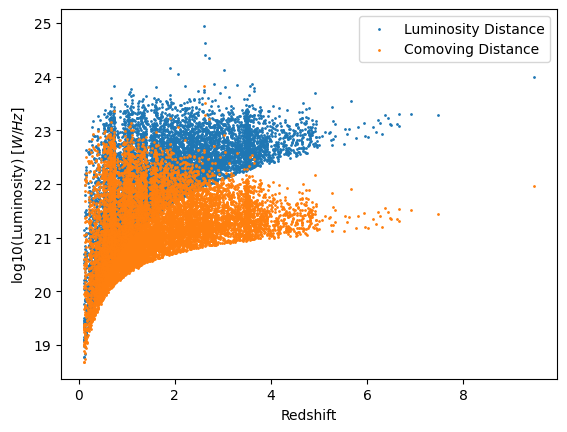

In [17]:
# Mask AB mag limit
mag_ab = 25 - 2.5*np.log10(df['FKs']) # apparent magnitude -> AB magnitude
mask = (mag_ab <= mag_lim)
fks = df['FKs'].values[mask] # apparent magnitude
z = df['zpk'].values[mask] # redshift
f = 0.3631 * fks * 10**-32  # uJy -> W/m^2/Hz

# Luminosity Distance
d = cosmo.luminosity_distance(z).to(u.m).value # meters
luminosity = 4 * np.pi * (d**2) * f # m^2 * W/m^2/Hz = W/Hz

# Comoving Distance
d_cm = cosmo.comoving_distance(z).to(u.m).value # meters
luminosity_cm = 4 * np.pi * (d_cm**2) * f # m^2 * W/m^2/Hz = W/Hz

plt.scatter(z, np.log10(luminosity), s=1, label='Luminosity Distance')
plt.scatter(z, np.log10(luminosity_cm), s=1, label='Comoving Distance')
plt.ylabel('log10(Luminosity) $[W/Hz]$')
plt.xlabel('Redshift')
plt.legend()
plt.show()

### Luminosity-distance relationship

1) Calculate the luminosity of each galaxy given the parameters of: $D$ the luminosity distance in $m$ to the galaxy and the flux $F$ received from the galaxy in ${W}/{m^2}/Hz$ to get luminosity $L$ in $W/Hz$

$$
L = 4 \pi D^2 F
$$

2) Once the luminosity of each galaxy has been calculated, rearrange equation 1 to calculate the maximum distance. This equation uses the same luminosity $L$ as in equation 1) but with a new $F$: the flux limit of survey, $F_{lim}$. This effectively calculates the maximum possible distance of the galaxy given we know it's instrinsic luminosity but if it's flux were at the survey limit.

$$
D_{max} = \sqrt{\frac{L}{4 \pi F_{lim}}}
$$


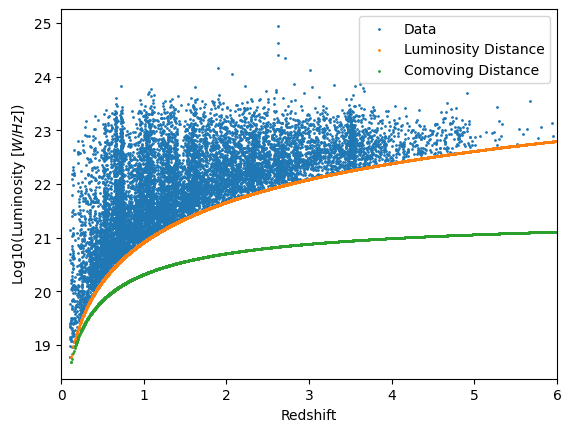

In [18]:
# Convert flux
f_lim = 10 ** ((mag_lim + 56.1) / -2.5) # AB mag -> W/m^2/Hz

# Maximum luminosity distance
dmaxs = np.sqrt(luminosity / (4*np.pi*f_lim)) # meters
dmaxs *= 3.241 * 10 ** -23 # meters -> Mpc

# Maximum comoving distance
dmaxs_cm = np.sqrt(luminosity_cm / (4*np.pi*f_lim)) # meters
dmaxs_cm *= 3.241 * 10 ** -23 # meters -> Mpc
dmaxs_cm[dmaxs_cm > 10000] = 10000 # z~15

# Plot luminosity vs redshift
z_lim_cm = z_at_value(cosmo.comoving_distance, dmaxs_cm * u.Mpc)
z_lim = z_at_value(cosmo.luminosity_distance, dmaxs * u.Mpc)

plt.scatter(z, np.log10(luminosity), s=1, label='Data')
plt.scatter(z_lim, np.log10(luminosity), s=1, label='Luminosity Distance')
plt.scatter(z_lim_cm, np.log10(luminosity_cm), s=1, label='Comoving Distance')
plt.xlabel('Redshift')
plt.ylabel('Log10(Luminosity [$W/Hz$])')
plt.xlim(redshift_bins[0][0], redshift_bins[-1][1])
plt.legend()
plt.show()

### Luminosity Bin Limits vs Maximum Redshift

This shows that when calculating the maximum possible distance, to eventually calculate volume, the luminosities no longer follow the `luminosity_distance` limit and instead follow the `comoving_distance` limit. This must be corrected by excluding sources below the `luminosity_distance` limit.

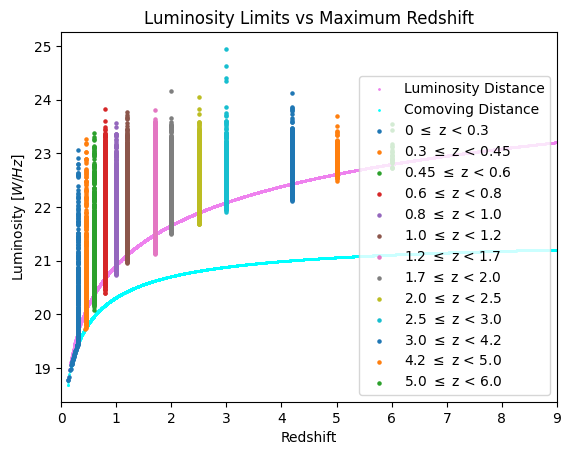

In [19]:
plt.scatter(z_lim, np.log10(luminosity), s=1, label='Luminosity Distance', color='violet')
plt.scatter(z_lim_cm, np.log10(luminosity_cm), s=1, label='Comoving Distance', color='cyan')
for (z_min, z_max), n_lum_bins in zip(redshift_bins, all_lum_bins):
    mask = (z >= z_min) & (z < z_max)
    
    lum_bin = np.log10(luminosity)[mask]
    
    # Find the maximum distance for the redshift bin
    dmin = cosmo.comoving_distance(z_min).value # Mpc
    dmax = cosmo.comoving_distance(z_max).value # Mpc
    
    # Find the maximum distance for each source
    dmaxs = np.sqrt(luminosity[mask] / (4*np.pi*f_lim)) # meters
    dmaxs *= 3.241 * 10 ** -23 # meters -> Mpc
    
    # Only use luminosity bins that are possible in the redshift range
    d_mask = dmaxs >= dmin
    dmaxs = dmaxs[d_mask]
    lum_bin = lum_bin[d_mask]
        
    # Limit the distance to the maximum distance
    dmaxs[dmaxs > dmax] = dmax
    
    # Find the redshift at the maximum distance
    z_lims = z_at_value(cosmo.comoving_distance, dmaxs * u.Mpc)
    plt.scatter(z_lims, lum_bin, s=5, label=f'{z_min} $\leq$ z < {z_max}')
    
plt.title('Luminosity Limits vs Maximum Redshift')
plt.xlabel('Redshift')
plt.ylabel('Luminosity [$W/Hz$]')
plt.legend(loc='lower right')
plt.xlim(redshift_bins[0][0], redshift_bins[-1][1]+3)
plt.show()

### Calculate Maximum Volume

Correcting for the above

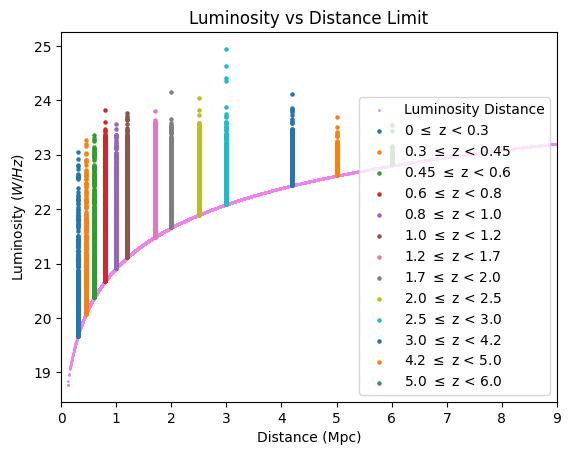

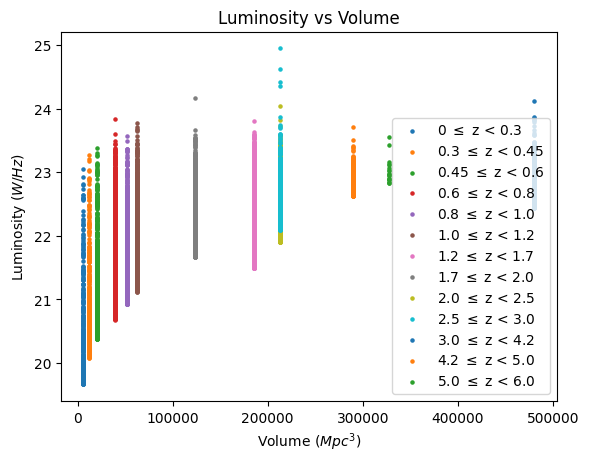

In [20]:
def lum_lim(z):
    """ Luminosity distance luminosity limit as a function of redshift """
    d = cosmo.luminosity_distance(z).to(u.m).value # meters
    return 4 * np.pi * (d**2) * f_lim # m^2 * W/m^2/Hz = W/Hz 

all_data = []

plt.scatter(z_lim, np.log10(luminosity), s=1, label='Luminosity Distance', color='violet')
for z_min, z_max in redshift_bins:
    mask = (z >= z_min) & (z < z_max)
    
    lum_bin = np.log10(luminosity)[mask]
    
    # Calculate the minimum and maximum distance of the redshift bin
    dmin = cosmo.comoving_distance(z_min).value # Mpc
    dmax = cosmo.comoving_distance(z_max).value # Mpc
    
    # Find the maximum distance for each source
    dmaxs = np.sqrt(luminosity[mask] / (4*np.pi*f_lim)) # meters
    dmaxs *= 3.241 * 10 ** -23 # meters -> Mpc
    
    # Distances must be greater than the minimum distance
    d_mask = dmaxs >= dmin
    
    # Lumiosity bins must be greater than or equal to the minimum luminosity (from luminosity distance)
    l = lum_lim(z_max)
    mlim_mask = lum_bin >= np.log10(l)
    
    # Apply masks
    dmaxs = dmaxs[d_mask & mlim_mask]
    lum_bin = lum_bin[d_mask & mlim_mask]
    
    # If the maximum distance is greater than the maximum redshift bin distance, set it to the maximum redshift bin distance
    dmaxs[dmaxs > dmax] = dmax
    
    # Calculate the minimum volume of the redshift bin
    vmin = 4/3 * np.pi * dmin**3 # Mpc^3

    # Calculate the maximum volume of each luminosity bin
    vmaxs = 4/3 * np.pi * dmaxs**3 # Mpc^3
    
    # Total volume probed accounting for survey area
    vol = (vmaxs - vmin) * (survey_area / 41253) # Mpc^3
    
    all_data.append([vol, lum_bin])

    z_lims = z_at_value(cosmo.comoving_distance, dmaxs * u.Mpc)
    plt.scatter(z_lims, lum_bin, s=5, label=f'{z_min} $\leq$ z < {z_max}')    

plt.title('Luminosity vs Distance Limit')
plt.xlabel('Distance (Mpc)')
plt.ylabel('Luminosity $(W/Hz)$')
plt.xlim(redshift_bins[0][0], redshift_bins[-1][1]+3)
plt.legend(loc='lower right')
plt.show()

plt.title('Luminosity vs Volume')
for (v, m), (z_start, z_end) in zip(all_data, redshift_bins):
    plt.scatter(v, m, s=5, label=f'{z_start} $\leq$ z < {z_end}')
plt.xlabel('Volume $(Mpc^3)$')
plt.ylabel('Luminosity $(W/Hz)$')
plt.legend()
plt.show()

### Counts Histograms

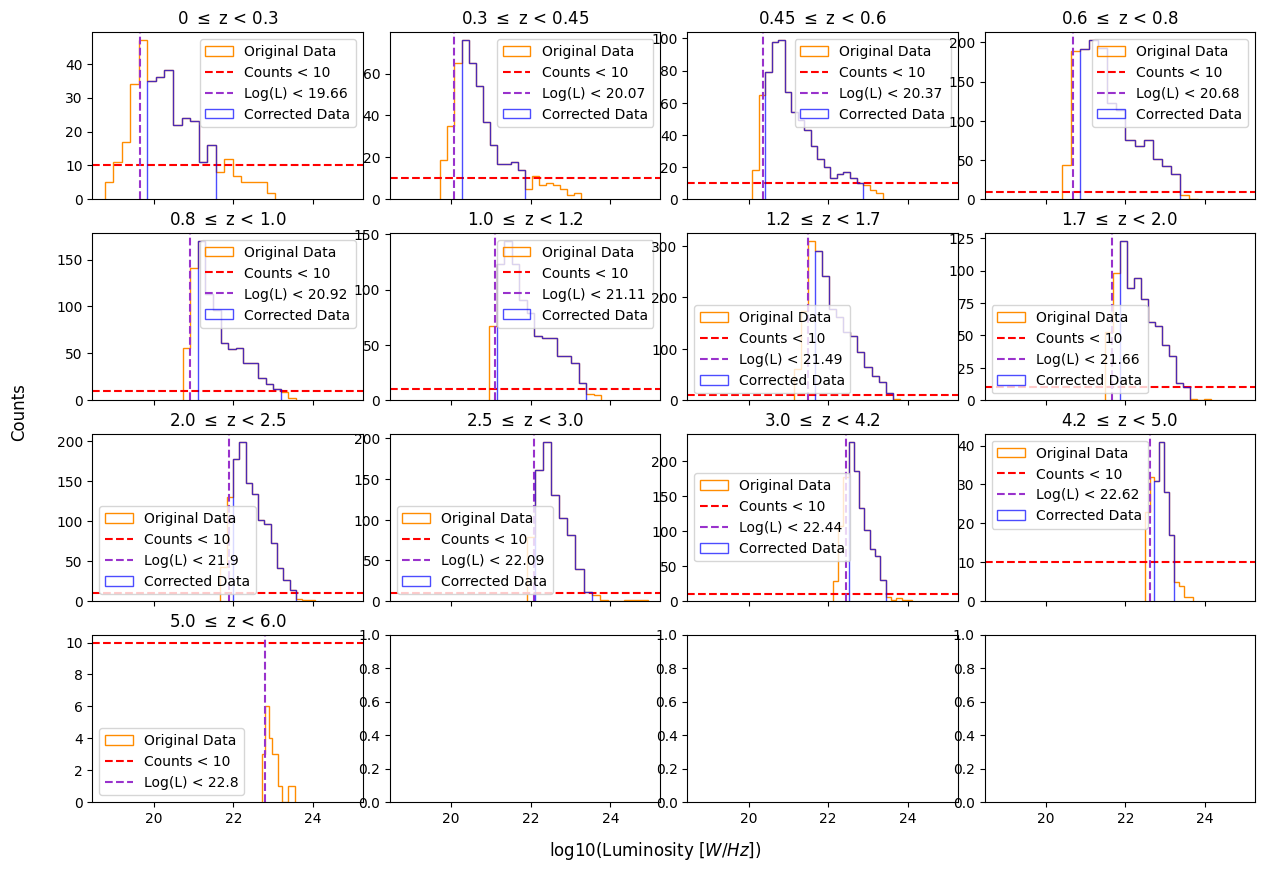

In [26]:
fig, axes = plt.subplots(4, 4, figsize=(15, 10), sharex=True)
bin_edges = []
for (z_start, z_end), (vol, lum), bins, ax in zip(redshift_bins, all_data, all_lum_bins, axes.flatten()):
    
    # Bin the original data per redshift bin
    _, b, _ = ax.hist(np.log10(luminosity)[(z >= z_start) & (z < z_end)], bins=bins, histtype='step', label='Original Data', color='darkorange')
    
    # Bin the new data with the same bins
    c, b = np.histogram(lum, bins=b)
    centers = (b[:-1] + b[1:]) / 2 # bin centers
    
    # Mask the bins with less than the minimum count
    c_mask = c >= min_count
    for _ in range(2): # should only need to run twice
        nci = np.where(np.diff(np.where(c_mask)[0]) != 1)[0] # non-consecutive indices: mask non-consecutive True values
        c_mask[np.where(c_mask)[0][nci + 1]] = False
    
    b = b[1:][c_mask] # this [1:] removes the first bin edge which is impacted by the mask (would be a fraction of the bin width)
    centers = centers[c_mask]
    c = c[c_mask]
    
    # Plot the mask cutoff
    ax.axhline(min_count, color='red', linestyle='--', label=f'Counts < {min_count}')
    ax.axvline(np.log10(lum_lim(z_end)), color='darkorchid', linestyle='--', label=f'Log(L) < {round(np.log10(lum_lim(z_end)), 2)}')
    ax.set_title(f'{z_start} $\leq$ z < {z_end}')
    
    # Skip if there are no bins
    if len(c) == 0:
        ax.legend()
        continue
    
    # Plot the new, corrected data
    ax.hist(centers, b, weights=c, histtype='step', label='Corrected Data', color='blue', alpha=0.7)
    ax.legend()
    bin_edges.append(b)

fig.supylabel('Counts', x=0.07)
fig.supxlabel('log10(Luminosity [$W/Hz$])', y=0.05)
plt.subplots_adjust(hspace=0.2, wspace=0.1)
plt.show()

### Luminosity Function

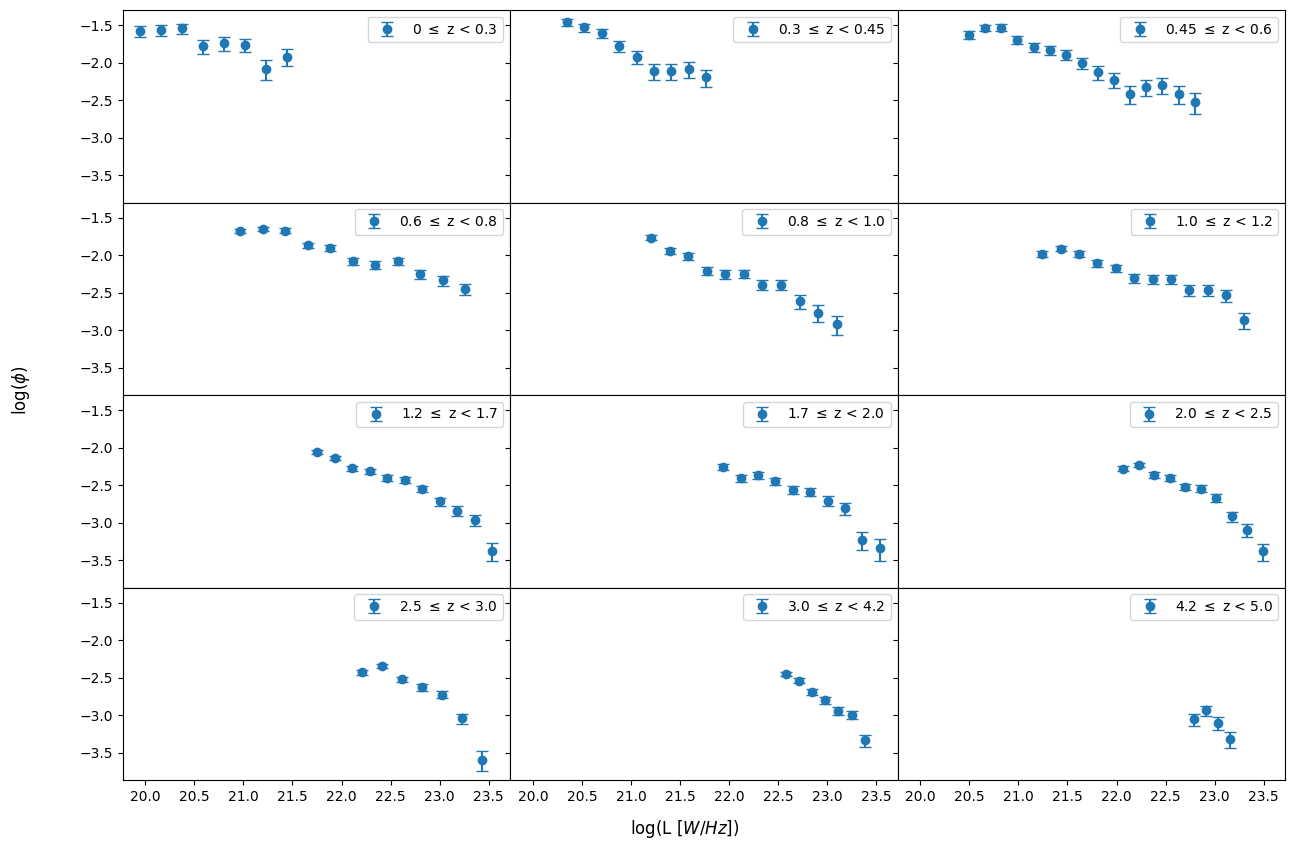

In [22]:
lum_centers, phi, phi_e = [], [], []

# Volume and luminosity are already binned by redshift
for (vol, lum), bin, in zip(all_data, bin_edges):
    
    # delta_log_l = np.diff(np.log10(np.abs(bin[::-1])))[0]
    delta_log_l = np.diff(bin)[0]
    
    lum_centers_z, phi_z, phi_e_z = [], [], []

    # Bin by luminosity
    for lum_start, lum_end in zip(bin, bin[1:]):
        mask = (lum >= lum_start) & (lum < lum_end)
        vol_lum_bin = vol[mask]
        
        # Calculate the number density
        phi_val = (1 / delta_log_l) * np.sum(1 / vol_lum_bin)
        phi_err = (1 / delta_log_l) * np.sqrt(np.sum(1 / (vol_lum_bin ** 2)))
        
        # Save the luminosity bin and number density
        lum_centers_z.append((lum_start + lum_end) / 2)
        phi_z.append(phi_val)
        phi_e_z.append(phi_err)
    
    # Save the luminosity bins and number densities
    lum_centers.append(lum_centers_z)
    phi.append(phi_z)
    phi_e.append(np.array(phi_e_z))

fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharex=True, sharey=True)
for (z_start, z_end), lum, p, e, ax in zip(redshift_bins, lum_centers, phi, phi_e, axes.flatten()):
    yerr = [np.log10(p) - np.log10(p - e), np.log10(p + e) - np.log10(p)]
    ax.errorbar(lum, np.log10(p), yerr=yerr, label=f'{z_start} $\leq$ z < {z_end}', fmt='o', capsize=4)
    ax.legend()

fig.supxlabel('log(L [$W/Hz$])', y=0.05)
fig.supylabel('log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)

### Schechter Fit

C:\Users\n10480129\AppData\Local\Temp\ipykernel_23984\3824182310.py:2: RuntimeWarning: overflow encountered in power
  return phi_star * 10 ** (-0.4*(1-alpha)*(M_star-M)) * np.exp(-10.**(-0.4*(M_star-M)))


0 <= z < 0.3 Function fit:
M_star = 2.09e+01
phi_star = 4.62e-02
alpha = 9.13e-01


0.3 <= z < 0.45 Function fit:
M_star = 3.08e+01
phi_star = 1.97e-08
alpha = 2.50e+00


0.45 <= z < 0.6 Function fit:
M_star = 2.16e+01
phi_star = 3.03e-02
alpha = 1.29e+00


0.6 <= z < 0.8 Function fit:
M_star = 2.32e+01
phi_star = 9.27e-03
alpha = 1.52e+00


0.8 <= z < 1.0 Function fit:
M_star = 3.50e+01
phi_star = 2.43e-10
alpha = 2.42e+00


1.0 <= z < 1.2 Function fit:
M_star = 2.33e+01
phi_star = 5.17e-03
alpha = 1.54e+00


1.2 <= z < 1.7 Function fit:
M_star = 2.32e+01
phi_star = 4.16e-03
alpha = 1.76e+00


1.7 <= z < 2.0 Function fit:
M_star = 2.24e+01
phi_star = 1.01e-02
alpha = 9.69e-01


2.0 <= z < 2.5 Function fit:
M_star = 2.17e+01
phi_star = 1.62e-02
alpha = -1.61e-02


2.5 <= z < 3.0 Function fit:
M_star = 2.11e+01
phi_star = 2.93e-03
alpha = -2.02e+00


3.0 <= z < 4.2 Function fit:
M_star = 2.24e+01
phi_star = 1.30e-02
alpha = 1.73e+00




C:\Users\n10480129\AppData\Local\Temp\ipykernel_23984\3824182310.py:2: RuntimeWarning: invalid value encountered in multiply
  return phi_star * 10 ** (-0.4*(1-alpha)*(M_star-M)) * np.exp(-10.**(-0.4*(M_star-M)))


4.2 <= z < 5.0 Function fit:
M_star = 1.91e+01
phi_star = 3.85e-40
alpha = -3.24e+01




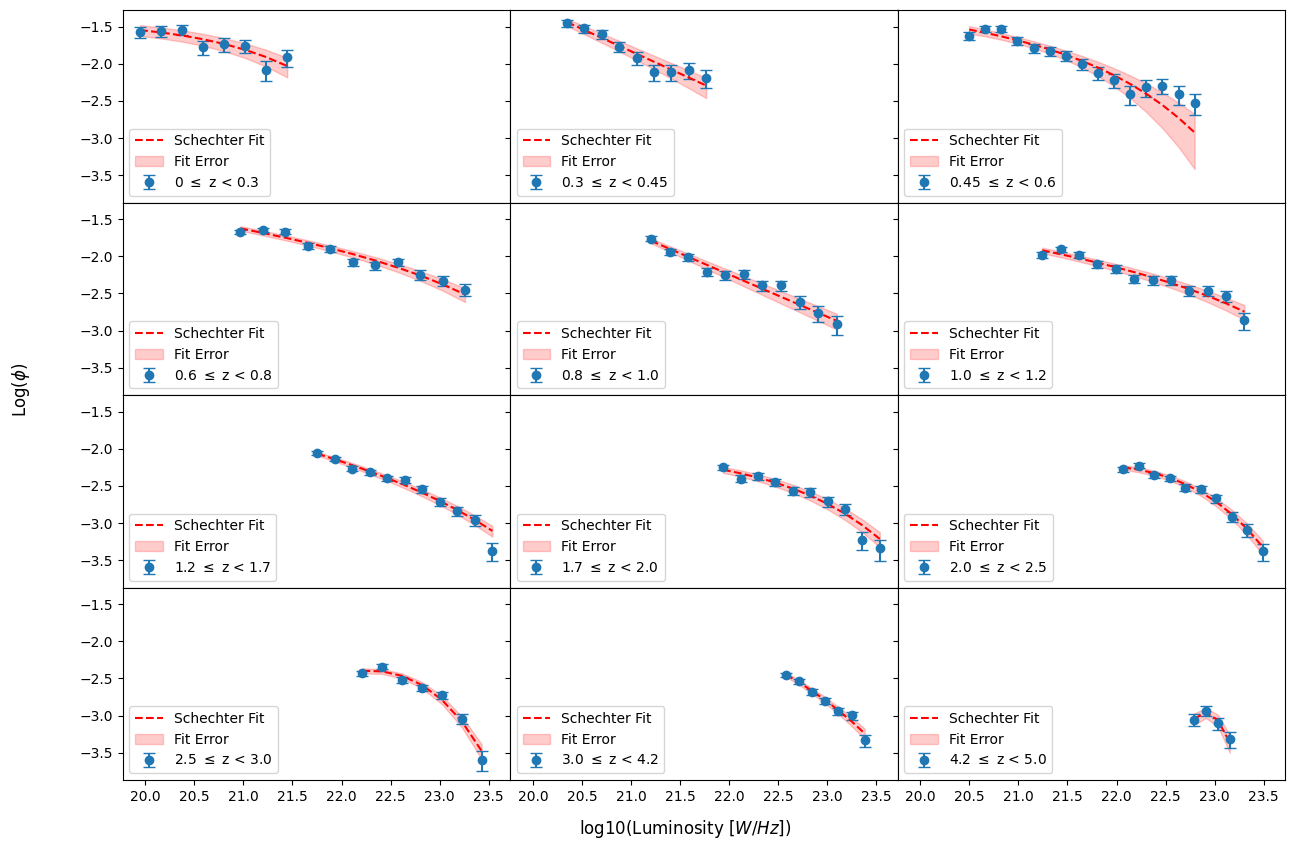

In [24]:
def schechter_luminosity(M, M_star, phi_star, alpha):
    return phi_star * 10 ** (-0.4*(1-alpha)*(M_star-M)) * np.exp(-10.**(-0.4*(M_star-M)))

fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharex=True, sharey=True)
for (z_start, z_end), lum, p, e, ax in zip(redshift_bins, lum_centers, phi, phi_e, axes.flatten()):

    if len(lum) == 0:
        print(f'No data for {z_start} <= z < {z_end}')
        continue
    
    # Attempt to fit the data
    p0=[lum[0], 0.001, -0.9]
    try:
        params, covars = curve_fit(schechter_luminosity, lum, p, p0=p0, maxfev=10000)
        p_up, _ = curve_fit(schechter_luminosity, lum, p+e, p0=p0, maxfev=10000)
        p_down, _ = curve_fit(schechter_luminosity, lum, p-e, p0=p0, maxfev=10000)
    except RuntimeError:
        print(f'Failed to fit {z_start} <= z < {z_end}. Maxfev reached.')
        continue
    except TypeError:
        print(f'Failed to fit {z_start} <= z < {z_end}. Params: {len(params)} > data points: {len(lum)}.')
        continue
    
    print(f'{z_start} <= z < {z_end} Function fit:')
    print(f'M_star = {params[0]:.2e}')
    print(f'phi_star = {params[1]:.2e}')
    print(f'alpha = {params[2]:.2e}')
    print('\n')
    
    # Plot the data
    yerr = [np.log10(p) - np.log10(p - e), np.log10(p + e) - np.log10(p)]
    ax.errorbar(lum, np.log10(p), yerr=yerr, label=f'{z_start} $\leq$ z < {z_end}', fmt='o', capsize=4)
    ax.plot(lum, np.log10(schechter_luminosity(lum, *params)), color='red', label='Schechter Fit', linestyle='--')
    ax.fill_between(lum, 
        np.log10(schechter_luminosity(lum, *p_down)),
        np.log10(schechter_luminosity(lum, *p_up)), 
        color='red', alpha=0.2, label='Fit Error') 
    ax.legend(loc='lower left')

fig.supxlabel('log10(Luminosity [$W/Hz$])', y=0.05)
fig.supylabel('Log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

### Saunders Fit

0 <= z < 0.3 Function fit:
M_star = 1.61e+01
phi_star = 2.50e-04
alpha = -1.92e+00
sigma = 4.63e-01


0.3 <= z < 0.45 Function fit:
M_star = 2.82e+01
phi_star = 6.58e-07
alpha = 2.50e+00
sigma = 2.49e-01


0.45 <= z < 0.6 Function fit:
M_star = 1.67e+01
phi_star = 2.82e-04
alpha = -2.12e+00
sigma = 4.30e-01


0.6 <= z < 0.8 Function fit:
M_star = 1.72e+01
phi_star = 1.11e-02
alpha = 1.44e-02
sigma = 6.56e-01




C:\Users\n10480129\AppData\Local\Temp\ipykernel_23984\3403638337.py:2: RuntimeWarning: overflow encountered in power
  return phi_star * 10 ** (-0.4*(1-alpha)*(M_star-M)) * np.exp(-1 / (2 * sigma ** 2) * (np.log10(1 + 10 ** (-0.4 * (M_star-M))))**2)


0.8 <= z < 1.0 Function fit:
M_star = 3.01e+01
phi_star = 1.49e-07
alpha = 2.42e+00
sigma = 2.18e-01


1.0 <= z < 1.2 Function fit:
M_star = 1.73e+01
phi_star = 6.57e-03
alpha = 4.54e-02
sigma = 6.60e-01


1.2 <= z < 1.7 Function fit:
M_star = 3.35e+01
phi_star = 1.86e-07
alpha = 2.00e+00
sigma = 3.31e-05


1.7 <= z < 2.0 Function fit:
M_star = 3.30e+01
phi_star = 2.56e-05
alpha = 1.53e+00
sigma = 4.11e-05


2.0 <= z < 2.5 Function fit:
M_star = 1.73e+01
phi_star = 3.53e-12
alpha = -9.05e+00
sigma = 2.82e-01


2.5 <= z < 3.0 Function fit:
M_star = 1.81e+01
phi_star = 2.07e-17
alpha = -1.62e+01
sigma = 2.06e-01


3.0 <= z < 4.2 Function fit:
M_star = 3.13e+01
phi_star = 1.97e-08
alpha = 2.53e+00
sigma = 2.13e-04




C:\Users\n10480129\AppData\Local\Temp\ipykernel_23984\3403638337.py:2: RuntimeWarning: invalid value encountered in multiply
  return phi_star * 10 ** (-0.4*(1-alpha)*(M_star-M)) * np.exp(-1 / (2 * sigma ** 2) * (np.log10(1 + 10 ** (-0.4 * (M_star-M))))**2)


Failed to fit 4.2 <= z < 5.0. Maxfev reached.


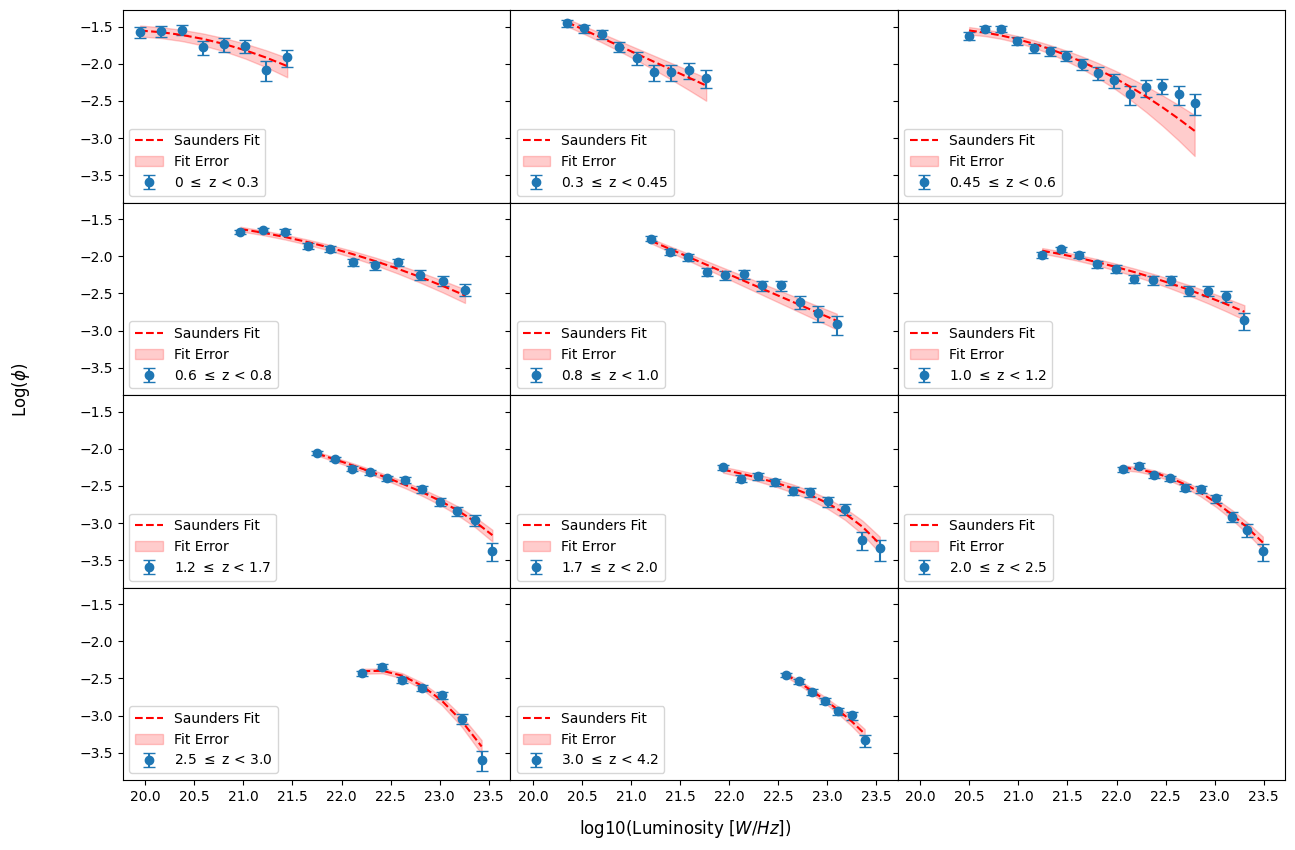

In [25]:
def saunders_luminosity(M, M_star, phi_star, alpha, sigma):
    return phi_star * 10 ** (-0.4*(1-alpha)*(M_star-M)) * np.exp(-1 / (2 * sigma ** 2) * (np.log10(1 + 10 ** (-0.4 * (M_star-M))))**2)

fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharex=True, sharey=True)
for (z_start, z_end), lum, p, e, ax in zip(redshift_bins, lum_centers, phi, phi_e, axes.flatten()):
    
    if len(lum) == 0:
        print(f'No data for {z_start} <= z < {z_end}')
        continue
    
    # Attempt to fit the data
    p0 = [lum[0], 0.001, -0.9, 0.1]
    try:
        params, _ = curve_fit(saunders_luminosity, lum, p, p0=p0, maxfev=100000)
        p_up, _ = curve_fit(saunders_luminosity, lum, p+e, p0=p0, maxfev=100000)
        p_down, _ = curve_fit(saunders_luminosity, lum, p-e, p0=p0, maxfev=100000)
    except RuntimeError:
        print(f'Failed to fit {z_start} <= z < {z_end}. Maxfev reached.')
        continue
    except TypeError:
        print(f'Failed to fit {z_start} <= z < {z_end}. Params: {len(params)} > data points: {len(lum)}.')
        continue       
    
    print(f'{z_start} <= z < {z_end} Function fit:')
    print(f'M_star = {params[0]:.2e}')
    print(f'phi_star = {params[1]:.2e}')
    print(f'alpha = {params[2]:.2e}')
    print(f'sigma = {params[3]:.2e}')
    print('\n')
    
    # Plot the data
    yerr = [np.log10(p) - np.log10(p - e), np.log10(p + e) - np.log10(p)]
    ax.errorbar(lum, np.log10(p), yerr=yerr, label=f'{z_start} $\leq$ z < {z_end}', fmt='o', capsize=4)
    ax.plot(lum, np.log10(saunders_luminosity(lum, *params)), color='red', label='Saunders Fit', linestyle='--')   
    ax.fill_between(lum, 
        np.log10(saunders_luminosity(lum, *p_down)), 
        np.log10(saunders_luminosity(lum, *p_up)), 
        color='red', alpha=0.2, label='Fit Error')
    ax.legend(loc='lower left')

fig.supxlabel('log10(Luminosity [$W/Hz$])', y=0.05)
fig.supylabel('Log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()